# Water test
--

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import json
import urllib.request

import time
from scipy.stats import linregress

In [13]:
#import the csv file for arsenic data over CA history
ar_data_import = "../CA_Water_Analysis/Ar-Water-Lab-Data.csv"

ar_data = pd.read_csv(ar_data_import)
ar_data.head()

,station_id,station_name,full_station_name,station_number,station_type,latitude,longitude,status,county_name,sample_code,sample_date,sample_depth,sample_depth_units,parameter,result,reporting_limit,units,method_name
0,13460,03S01E11H001M,03S01E11H001M,03S01E11H001M,Groundwater,37.6881,121.8270,Review Status Unknown,Alameda,WDIS_0309039,07/11/1975 11:30,NaN,Feet,Total Arsenic,0.0,0.001,mg/L,"Std Method 3500-As, C"
1,13494,03S02E07P003M,03S02E07P003M,03S02E07P003M,Groundwater,37.6809,121.7996,Review Status Unknown,Alameda,WDIS_0003482,02/12/1975 00:00,NaN,Feet,Total Arsenic,0.0,0.001,mg/L,UnkMod Arsenic
2,13494,03S02E07P003M,03S02E07P003M,03S02E07P003M,Groundwater,37.6809,121.7996,Review Status Unknown,Alameda,WDIS_0003485,03/05/1980 11:00,NaN,Feet,Total Arsenic,0.0,0.001,mg/L,UnkMod Arsenic
3,13494,03S02E07P003M,03S02E07P003M,03S02E07P003M,Groundwater,37.6809,121.7996,Review Status Unknown,Alameda,WDIS_0309048,04/22/1986 13:35,NaN,Feet,Total Arsenic,0.0,0.001,mg/L,UnkMod Arsenic
4,13494,03S02E07P003M,03S02E07P003M,03S02E07P003M,Groundwater,37.6809,121.7996,Review Status Unknown,Alameda,WDIS_0309041,05/06/1974 00:00,NaN,Feet,Total Arsenic,0.0,0.001,mg/L,UnkMod Arsenic


In [14]:

#sort by the total amount of arsenic found 
sorted_ar_df = ar_data.sort_values(['result'], ascending=False)
#create a new dataframe from top offenders
top_offender_df = sorted_ar_df.head(100)

sorted_top_offender_df = top_offender_df.sort_values(['station_type'], ascending=False)

sorted_top_offender_df


,station_id,station_name,full_station_name,station_number,station_type,latitude,longitude,status,county_name,sample_code,sample_date,sample_depth,sample_depth_units,parameter,result,reporting_limit,units,method_name
30969,206,TWITCHELL01,Twitchell Island Sample 01,B9V80621369,Surface Water,38.1052,121.6173,Review Status Unknown,Sacramento,C1091A0836,10/18/1991 09:00,1.00,Meters,Dissolved Arsenic,5880.0,0.001,mg/L,Std Method 3114 C
44086,1806,MILL C NR MINERAL,MILL C NR MINERAL,A4418000,Surface Water,40.3621,121.5055,Review Status Unknown,Tehama,N0218B0268,02/13/2018 09:40,0.15,Meters,Dissolved Arsenic,98.7,0.100,ug/L,EPA 1638 (D)
44096,1806,MILL C NR MINERAL,MILL C NR MINERAL,A4418000,Surface Water,40.3621,121.5055,Review Status Unknown,Tehama,N0515B0361,05/12/2015 11:40,0.15,Meters,Dissolved Arsenic,90.8,0.100,ug/L,EPA 1638 (D)
44118,1806,MILL C NR MINERAL,MILL C NR MINERAL,A4418000,Surface Water,40.3621,121.5055,Review Status Unknown,Tehama,N1117B27840,11/20/2017 09:20,0.15,Meters,Dissolved Arsenic,93.7,0.100,ug/L,EPA 1638 (D)
12825,702,Semi Tropic 3 Pumpin,Semi Tropic 3 arsenic monitoring,KA020699,Surface Water,35.9833,119.9833,Review Status Unknown,Kern,SJA0907B1020,09/18/2007 09:10,1.00,Meters,Dissolved Chloride,96.0,1.000,mg/L,EPA 300.0 28d Hold
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25466,44099,42N17E06P001M,42N17E06P001M,42N17E06P001M,Groundwater,41.5309,120.0827,Review Status Unknown,Modoc,NB1012B5142,10/09/2012 15:45,0.15,Meters,Total Arsenic,192.0,0.100,ug/L,EPA 1638 (T)
1767,46640,17N01E24A003M,17N01E24A003M,17N01E24A003M,Groundwater,39.3171,121.8004,Review Status Unknown,Butte,NB0507B0686,05/01/2007 13:45,0.00,Meters,Dissolved Arsenic,78.7,0.100,ug/L,EPA 1638 (D)
19158,45462,29N14E19A03 M,29N14E19A003M,29N14E19A003M,Groundwater,40.3616,120.4338,Review Status Unknown,Lassen,NB0812B5016,08/13/2012 14:10,0.00,Meters,Total Arsenic,78.0,0.100,ug/L,EPA 1638 (T)
19156,45462,29N14E19A03 M,29N14E19A003M,29N14E19A003M,Groundwater,40.3616,120.4338,Review Status Unknown,Lassen,NB0812B5016,08/13/2012 14:10,0.00,Meters,Dissolved Arsenic,76.4,0.100,ug/L,EPA 1638 (D)


In [15]:
#count number of entries by county

station_num = sorted_ar_df['county_name'].unique().size
county_df = sorted_ar_df.groupby(['county_name']).count()
sorted_county_df = county_df.sort_values(['county_name'], ascending=False)
sorted_county_df

,station_id,station_name,full_station_name,station_number,station_type,latitude,longitude,status,sample_code,sample_date,sample_depth,sample_depth_units,parameter,result,reporting_limit,units,method_name
county_name,,,,,,,,,,,,,,,,,
Yuba,280,280,280,280,280,280,280,280,280,280,189,280,280,280,280,280,280
Yolo,735,735,735,735,735,735,735,735,735,735,536,735,735,727,735,735,735
Ventura,234,234,234,234,234,234,234,234,234,234,1,234,234,234,234,234,234
Tuolumne,48,48,48,48,48,48,48,48,48,48,1,48,48,48,48,48,48
Tulare,193,193,193,193,193,193,193,193,193,193,2,193,193,193,193,193,193
Trinity,165,165,165,165,165,165,165,165,165,165,82,165,165,161,165,165,165
Tehama,2794,2794,2794,2794,2794,2794,2794,2794,2794,2794,2355,2794,2794,2634,2794,2794,2794
Sutter,1003,1003,1003,1003,1003,1003,1003,1003,1003,1003,763,1003,1003,1003,1003,1003,1003
Stanislaus,76,76,76,76,76,76,76,76,76,76,10,76,76,76,76,76,76


<function matplotlib.pyplot.show(close=None, block=None)>

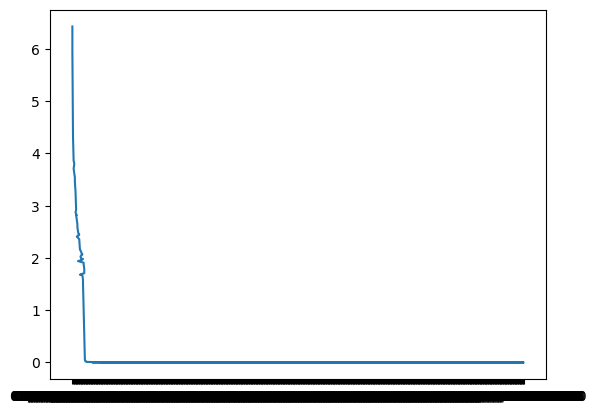

In [17]:
station_id = sorted_ar_df[(sorted_ar_df["station_id"]==12)]
plt.plot(station_id['sample_date'], station_id['result'])
plt.show


In [9]:
# base_url = 'https://data.ca.gov/api/3/action/datastore_create'

# query_url = base_url + "appid=" + api_key + "&q=" + city

url = "https://data.ca.gov/api/3/action/datastore_search?resource_id=819dfd68-4711-49e0-8d85-77f8238a1cd4&"

fileobj = urllib.request.urlopen(url)
response_dict = json.loads(fileobj.read())
response_dict_df = pd.DataFrame(response_dict)
response_dict_df

,help,success,result
_links,https://data.ca.gov/api/3/action/help_show?nam...,True,{'start': '/api/3/action/datastore_search?reso...
fields,https://data.ca.gov/api/3/action/help_show?nam...,True,"[{'type': 'int', 'id': '_id'}, {'type': 'text'..."
include_total,https://data.ca.gov/api/3/action/help_show?nam...,True,True
limit,https://data.ca.gov/api/3/action/help_show?nam...,True,100
records,https://data.ca.gov/api/3/action/help_show?nam...,True,"[{'status': 'Review Status Unknown', 'station_..."
records_format,https://data.ca.gov/api/3/action/help_show?nam...,True,objects
resource_id,https://data.ca.gov/api/3/action/help_show?nam...,True,819dfd68-4711-49e0-8d85-77f8238a1cd4
total,https://data.ca.gov/api/3/action/help_show?nam...,True,4523028
